In [21]:
# ARIMA Modeliranje i Evaluacija
# ===============================

import sys, os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

# Prophet for comparison
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("⚠️ Prophet nije dostupan")

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Our custom model function
from src.model import train_and_forecast_arima

print("🚀 ARIMA MODELIRANJE POTROŠNJE")
print("=" * 50)

# Set plotting style - fixed deprecated style
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    # Fallback to default seaborn style
    sns.set_style("whitegrid")
    
sns.set_palette("husl")

🚀 ARIMA MODELIRANJE POTROŠNJE


In [22]:
# 1. UČITAVANJE PRIPREMLJENIH PODATAKA
# ====================================

print("1️⃣ Učitavanje pripremljenih podataka...")

# Load data - FIXED: Remove dayfirst=True since dates are YYYY-MM-DD
df = pd.read_csv(
    '../data/historical_consumption.csv',
    skipinitialspace=True,
    parse_dates=['Datum']  # Removed dayfirst=True - dates are YYYY-MM-DD format
)

print(f"📊 Raw data loaded:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
display(df.head())

# Rename columns and set datetime index
df = df.rename(columns={'potrosnja':'Potrošnja'})
df = df.sort_values('Datum').set_index('Datum')

print(f"\n📊 After processing:")
print(f"  Shape: {df.shape}")
print(f"  Index type: {type(df.index)}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  NaN values: {df['Potrošnja'].isna().sum()}")

# SAFE way to set frequency - just set the freq attribute instead of using asfreq()
df.index.freq = 'D'

print(f"\n✅ Final dataset ready:")
print(f"  Shape: {df.shape}")
print(f"  Frequency: {df.index.freq}")
print(f"  NaN values: {df['Potrošnja'].isna().sum()}")

# Basic statistics
print(f"\n📊 Basic statistics:")
print(f"  Mean: {df['Potrošnja'].mean():.2f}")
print(f"  Std: {df['Potrošnja'].std():.2f}")  
print(f"  Min: {df['Potrošnja'].min():.2f}")
print(f"  Max: {df['Potrošnja'].max():.2f}")

display(df.head())
display(df.info())

1️⃣ Učitavanje pripremljenih podataka...
📊 Raw data loaded:
  Shape: (31, 2)
  Columns: ['Datum', 'potrosnja']


,Datum,potrosnja
0,2023-01-01,150
1,2023-01-02,200
2,2023-01-03,10
3,2023-01-04,300
4,2023-01-05,600



📊 After processing:
  Shape: (31, 1)
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Date range: 2023-01-01 00:00:00 to 2023-01-31 00:00:00
  NaN values: 0

✅ Final dataset ready:
  Shape: (31, 1)
  Frequency: <Day>
  NaN values: 0

📊 Basic statistics:
  Mean: 391.74
  Std: 452.54
  Min: 0.00
  Max: 2000.00


,Potrošnja
Datum,
2023-01-01,150
2023-01-02,200
2023-01-03,10
2023-01-04,300
2023-01-05,600


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2023-01-01 to 2023-01-31
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Potrošnja  31 non-null     int64
dtypes: int64(1)
memory usage: 496.0 bytes


None

2️⃣ Podjela na trening i test setove...
📊 PODJELA PODATAKA:
  Trening: 24 dana (2023-01-01 00:00:00 do 2023-01-24 00:00:00)
  Test: 7 dana (2023-01-25 00:00:00 do 2023-01-31 00:00:00)
  Omjer: 24/7 = 3.4


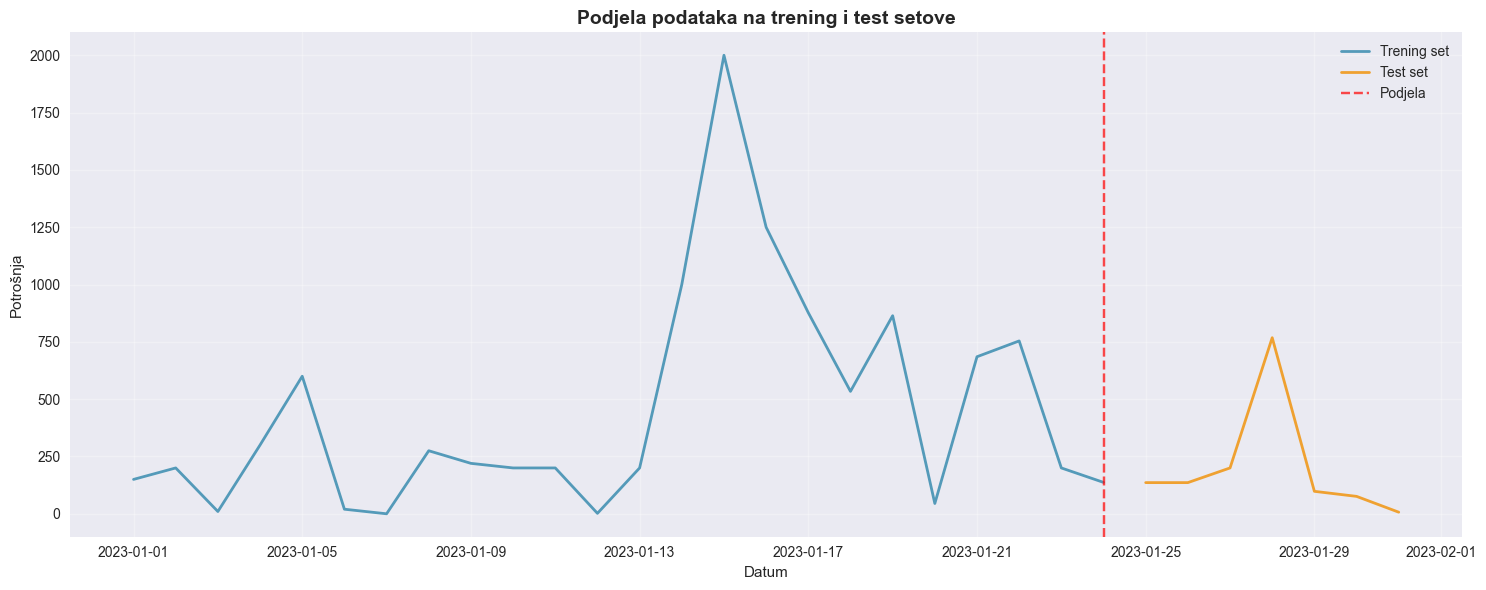

,Trening,Test
count,24.000000,7.000000
mean,446.791667,203.000000
std,485.793746,256.184179
min,0.000000,7.000000
25%,146.750000,87.000000
50%,210.000000,136.000000
75%,702.250000,168.000000
max,2000.000000,768.000000


In [23]:
# 2. TRAIN/TEST PODJELA
# =====================

print("2️⃣ Podjela na trening i test setove...")

# 80/20 split maintaining temporal order
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print(f"📊 PODJELA PODATAKA:")
print(f"  Trening: {len(train)} dana ({train.index.min()} do {train.index.max()})")
print(f"  Test: {len(test)} dana ({test.index.min()} do {test.index.max()})")
print(f"  Omjer: {len(train)}/{len(test)} = {len(train)/len(test):.1f}")

# Visualize the split
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['Potrošnja'], 
         color='#2E86AB', alpha=0.8, linewidth=2, label='Trening set')
plt.plot(test.index, test['Potrošnja'], 
         color='#F18F01', alpha=0.8, linewidth=2, label='Test set')
plt.axvline(x=train.index.max(), color='red', linestyle='--', alpha=0.7, label='Podjela')
plt.title('Podjela podataka na trening i test setove', fontsize=14, fontweight='bold')
plt.xlabel('Datum')
plt.ylabel('Potrošnja')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistics comparison
comparison = pd.DataFrame({
    'Trening': train['Potrošnja'].describe(),
    'Test': test['Potrošnja'].describe()
})
display(comparison)

In [24]:
# 3. ARIMA GRID SEARCH - PRONALAŽENJE NAJBOLJIH PARAMETARA
# ========================================================

print("3️⃣ ARIMA Grid Search za optimalne parametre...")

def arima_grid_search(data, p_range, d_range, q_range, criterion='aic'):
    """
    Performs grid search for ARIMA parameters
    """
    results = []
    
    print(f"🔍 Testiram {len(p_range) * len(d_range) * len(q_range)} kombinacija...")
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    # Fit ARIMA model
                    model = ARIMA(data, order=(p, d, q)).fit()
                    
                    results.append({
                        'p': p, 'd': d, 'q': q,
                        'aic': model.aic,
                        'bic': model.bic,
                        'hqic': model.hqic,
                        'log_likelihood': model.llf,
                        'model': model  # Store for later use
                    })
                    
                except Exception as e:
                    # Model failed to converge or other error
                    print(f"❌ ARIMA({p},{d},{q}) neuspješan: {str(e)[:50]}...")
                    continue
    
    if not results:
        print("❌ Nijedan model nije uspješno treniran!")
        return None
        
    # Convert to DataFrame and sort by criterion
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(criterion)
    
    print(f"✅ Uspješno trenirano {len(results_df)} modela")
    
    return results_df

# Define parameter ranges (small due to limited data)
p_range = range(0, 3)  # AR terms
d_range = range(0, 2)  # Differencing
q_range = range(0, 3)  # MA terms

# Perform grid search
grid_results = arima_grid_search(train['Potrošnja'], p_range, d_range, q_range)

if grid_results is not None:
    print(f"\n🏆 TOP 5 MODELA (po AIC):")
    print("=" * 50)
    
    top_models = grid_results.head(5)[['p', 'd', 'q', 'aic', 'bic']].copy()
    top_models['model_name'] = top_models.apply(lambda x: f"ARIMA({x['p']},{x['d']},{x['q']})", axis=1)
    
    display(top_models[['model_name', 'aic', 'bic']])
    
    # Get best model
    best_params = grid_results.iloc[0]
    best_order = (best_params['p'], best_params['d'], best_params['q'])
    best_model = best_params['model']
    
    print(f"\n🥇 NAJBOLJI MODEL: ARIMA{best_order}")
    print(f"   AIC: {best_params['aic']:.2f}")
    print(f"   BIC: {best_params['bic']:.2f}")
    
else:
    # Fallback to simple ARIMA(1,1,1)
    print("⚠️ Grid search neuspješan, koristim ARIMA(1,1,1)")
    best_order = (1, 1, 1)
    best_model = ARIMA(train['Potrošnja'], order=best_order).fit()

3️⃣ ARIMA Grid Search za optimalne parametre...
🔍 Testiram 18 kombinacija...
✅ Uspješno trenirano 18 modela

🏆 TOP 5 MODELA (po AIC):


,model_name,aic,bic
3,"ARIMA(0.0,1.0,0.0)",348.363879,349.499373
10,"ARIMA(1.0,1.0,1.0)",348.977675,352.384158
5,"ARIMA(0.0,1.0,2.0)",349.720405,353.126888
4,"ARIMA(0.0,1.0,1.0)",349.938069,352.209057
9,"ARIMA(1.0,1.0,0.0)",350.158327,352.429316



🥇 NAJBOLJI MODEL: ARIMA(0, 1, 0)
   AIC: 348.36
   BIC: 349.50


In [25]:
# 4. DETALJNI PREGLED NAJBOLJEG MODELA
# ====================================

print("4️⃣ Analiza najboljeg ARIMA modela...")

print(f"\n📊 SAŽETAK MODELA ARIMA{best_order}:")
print("=" * 50)
print(best_model.summary())

# Extract key information
print(f"\n📈 KLJUČNE METRIKE:")
print(f"  AIC: {best_model.aic:.2f}")
print(f"  BIC: {best_model.bic:.2f}")
print(f"  Log Likelihood: {best_model.llf:.2f}")
print(f"  Broj parametara: {best_model.df_model}")

# Model parameters
if hasattr(best_model, 'params'):
    print(f"\n🔧 PARAMETRI MODELA:")
    for param, value in best_model.params.items():
        print(f"  {param}: {value:.4f}")

# Make forecast on test period
forecast_result = best_model.get_forecast(steps=len(test))
forecast_values = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(test['Potrošnja'], forecast_values))
mae = mean_absolute_error(test['Potrošnja'], forecast_values)

# FIXED: Handle division by zero in MAPE calculation
test_nonzero = test['Potrošnja'][test['Potrošnja'] != 0]
forecast_nonzero = forecast_values[test['Potrošnja'] != 0]

if len(test_nonzero) > 0:
    mape = np.mean(np.abs((test_nonzero - forecast_nonzero) / test_nonzero)) * 100
else:
    mape = np.nan

print(f"\n🎯 PERFORMANSE NA TEST SETU:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
if not np.isnan(mape):
    print(f"  MAPE: {mape:.2f}%")
else:
    print(f"  MAPE: N/A (division by zero)")

# Direction accuracy (did we predict the right direction of change?)
if len(test) > 1:
    actual_direction = np.sign(test['Potrošnja'].diff().dropna())
    forecast_direction = np.sign(pd.Series(forecast_values, index=test.index).diff().dropna())
    direction_accuracy = (actual_direction == forecast_direction).mean() * 100
    print(f"  Točnost smjera: {direction_accuracy:.1f}%")

4️⃣ Analiza najboljeg ARIMA modela...

📊 SAŽETAK MODELA ARIMA(0, 1, 0):
                               SARIMAX Results                                
Dep. Variable:              Potrošnja   No. Observations:                   24
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -173.182
Date:                Tue, 15 Jul 2025   AIC                            348.364
Time:                        23:17:52   BIC                            349.499
Sample:                    01-01-2023   HQIC                           348.649
                         - 01-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.027e+05   6.35e+04      3.190      0.001    7.82e+04    3.27e+05
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (J

5️⃣ Vizualizacija predikcija...


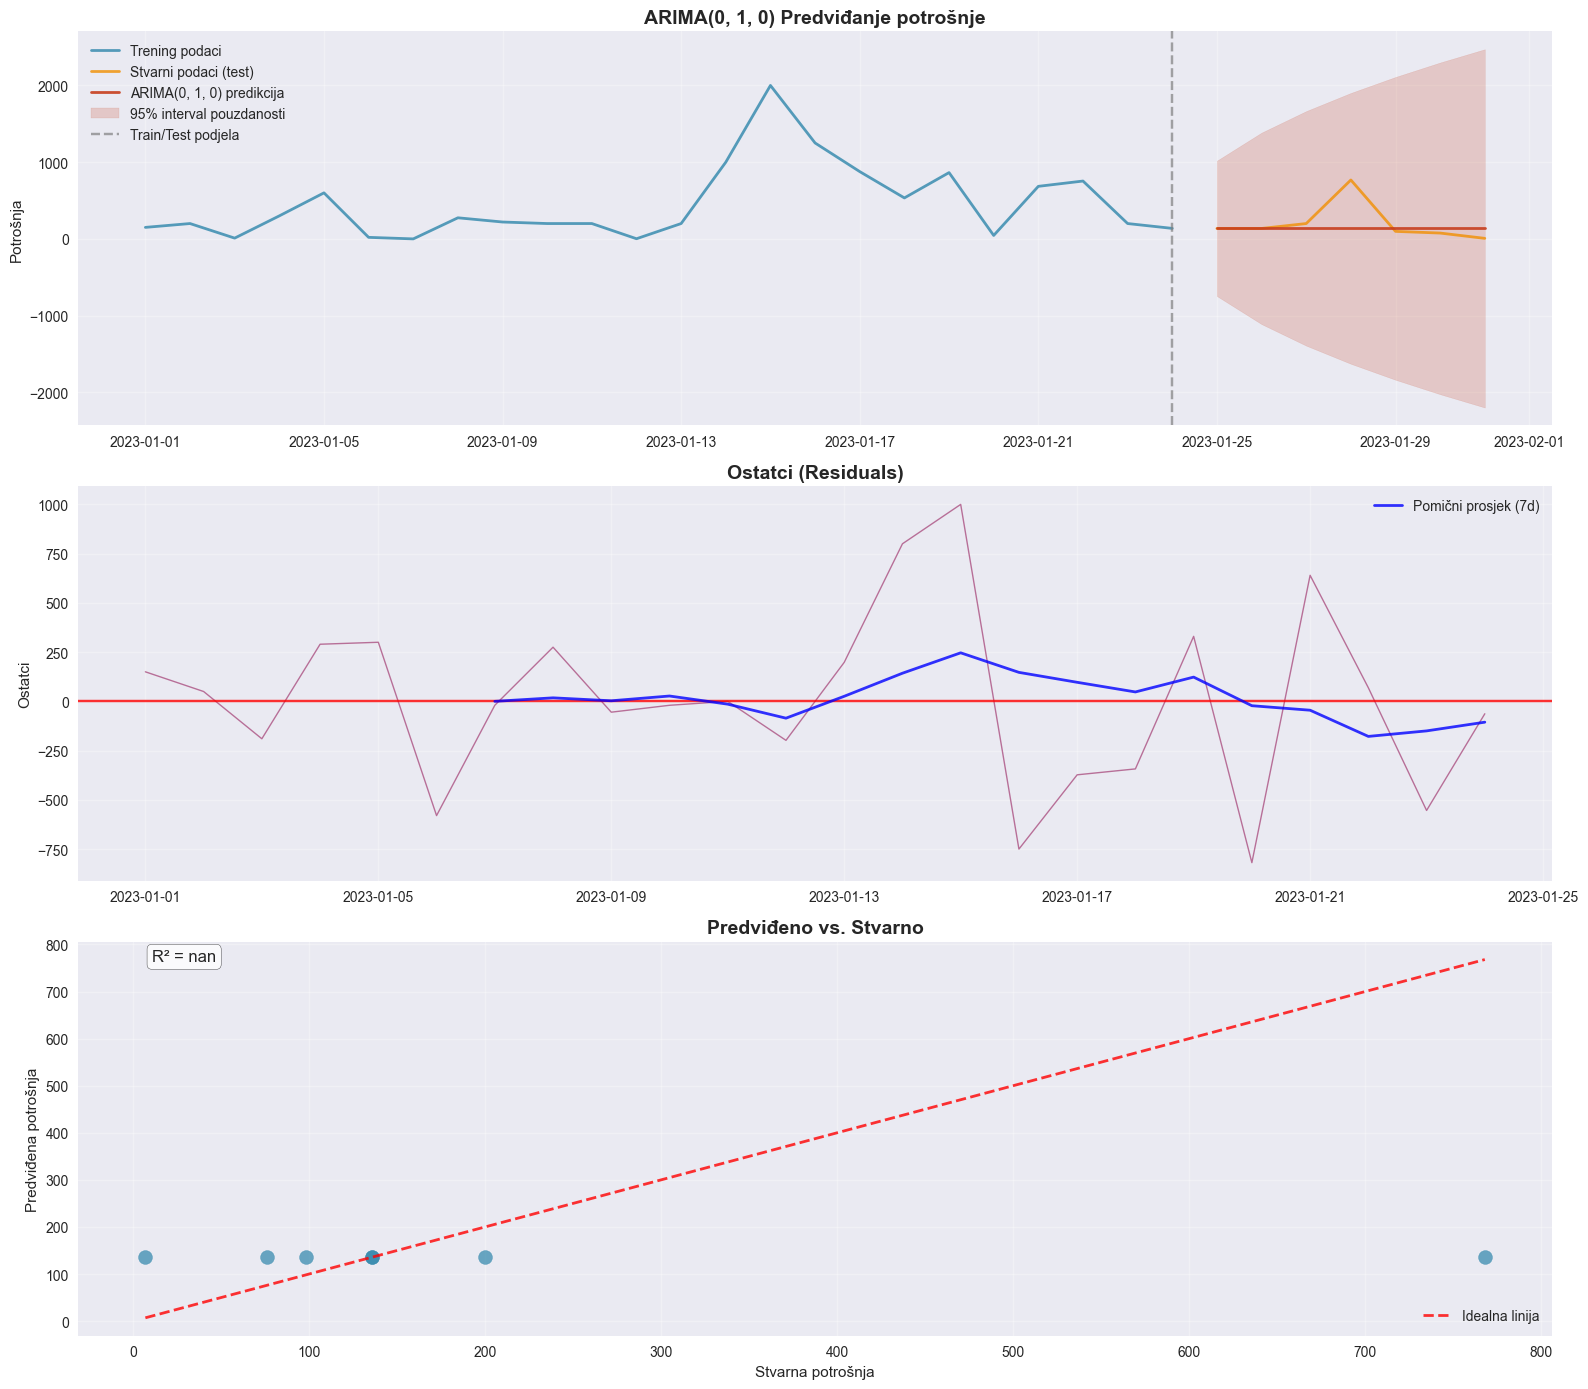


📊 SAŽETAK PERFORMANSI:


,Metrika,Vrijednost
0,RMSE,246.19
1,MAE,132.29
2,MAPE (%),298.90
3,R²,nan
4,Smjer točnost (%),16.7


In [26]:
# 5. VIZUALIZACIJA REZULTATA
# ==========================

print("5️⃣ Vizualizacija predikcija...")

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 1. Main forecast plot
axes[0].plot(train.index, train['Potrošnja'], 
             color='#2E86AB', alpha=0.8, linewidth=2, label='Trening podaci')
axes[0].plot(test.index, test['Potrošnja'], 
             color='#F18F01', alpha=0.8, linewidth=2, label='Stvarni podaci (test)')
axes[0].plot(test.index, forecast_values, 
             color='#C73E1D', alpha=0.9, linewidth=2, label=f'ARIMA{best_order} predikcija')

# Confidence intervals
axes[0].fill_between(test.index, 
                    forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                    color='#C73E1D', alpha=0.2, label='95% interval pouzdanosti')

axes[0].axvline(x=train.index.max(), color='gray', linestyle='--', alpha=0.7, label='Train/Test podjela')
axes[0].set_title(f'ARIMA{best_order} Predviđanje potrošnje', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Potrošnja')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residuals analysis
residuals = best_model.resid
axes[1].plot(train.index, residuals, color='#A23B72', alpha=0.7, linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='-', alpha=0.8)
axes[1].set_title('Ostatci (Residuals)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Ostatci')
axes[1].grid(True, alpha=0.3)

# Add rolling statistics for residuals
window = min(7, len(residuals)//3)
if window > 1:
    rolling_mean = residuals.rolling(window=window).mean()
    rolling_std = residuals.rolling(window=window).std()
    axes[1].plot(train.index, rolling_mean, color='blue', linewidth=2, alpha=0.8, 
                label=f'Pomični prosjek ({window}d)')
    axes[1].legend()

# 3. Forecast vs Actual scatter plot
axes[2].scatter(test['Potrošnja'], forecast_values, alpha=0.7, s=100, color='#2E86AB')
axes[2].plot([test['Potrošnja'].min(), test['Potrošnja'].max()], 
             [test['Potrošnja'].min(), test['Potrošnja'].max()], 
             'r--', alpha=0.8, linewidth=2, label='Idealna linija')

axes[2].set_xlabel('Stvarna potrošnja')
axes[2].set_ylabel('Predviđena potrošnja')
axes[2].set_title('Predviđeno vs. Stvarno', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add R² value
from scipy.stats import pearsonr
correlation, _ = pearsonr(test['Potrošnja'], forecast_values)
r_squared = correlation ** 2
axes[2].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[2].transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)

plt.tight_layout()
plt.show()

# Performance summary table
performance_summary = pd.DataFrame({
    'Metrika': ['RMSE', 'MAE', 'MAPE (%)', 'R²', 'Smjer točnost (%)'],
    'Vrijednost': [f"{rmse:.2f}", f"{mae:.2f}", f"{mape:.2f}", 
                  f"{r_squared:.3f}", f"{direction_accuracy:.1f}" if 'direction_accuracy' in locals() else 'N/A']
})

print(f"\n📊 SAŽETAK PERFORMANSI:")
display(performance_summary)

In [27]:
# 6. TESTIRANJE NAŠEG CUSTOM MODELA
# =================================

print("6️⃣ Testiranje custom model funkcije...")

# Test our custom function
try:
    print("🔍 Debug info:")
    print(f"  Train shape: {train.shape}")
    print(f"  Train NaN: {train['Potrošnja'].isna().sum()}")
    print(f"  Test shape: {test.shape}")
    print(f"  Test NaN: {test['Potrošnja'].isna().sum()}")
    print(f"  Best order: {best_order}")
    
    custom_result = train_and_forecast_arima(
        train, 
        order=best_order, 
        periods=len(test),
        valid=test['Potrošnja']
    )
    
    print(f"✅ Custom funkcija uspješno testirana")
    print(f"📊 Rezultati:")
    print(f"  AIC: {custom_result['aic']:.2f}")
    if 'rmse' in custom_result:
        print(f"  RMSE: {custom_result['rmse']:.2f}")
    else:
        print(f"  RMSE: No overlapping validation data")
    print(f"  Forecast shape: {custom_result['forecast'].shape}")
    
    # Compare with our direct ARIMA results
    print(f"\n🔍 USPOREDBA:")
    print(f"  Direct ARIMA RMSE: {rmse:.2f}")
    if 'rmse' in custom_result:
        print(f"  Custom funkcija RMSE: {custom_result['rmse']:.2f}")
        print(f"  Razlika: {abs(rmse - custom_result['rmse']):.4f}")
        
        if abs(rmse - custom_result['rmse']) < 0.01:
            print("✅ Rezultati se slažu!")
        else:
            print("⚠️ Mala razlika u rezultatima")
    
    display(custom_result['forecast'].head())
    
except Exception as e:
    print(f"❌ Greška u custom funkciji: {e}")
    print(f"❌ Tip greške: {type(e)}")
    import traceback
    traceback.print_exc()
    custom_result = None

6️⃣ Testiranje custom model funkcije...
🔍 Debug info:
  Train shape: (24, 1)
  Train NaN: 0
  Test shape: (7, 1)
  Test NaN: 0
  Best order: (0, 1, 0)
✅ Custom funkcija uspješno testirana
📊 Rezultati:
  AIC: 348.36
  RMSE: 246.19
  Forecast shape: (7,)

🔍 USPOREDBA:
  Direct ARIMA RMSE: 246.19
  Custom funkcija RMSE: 246.19
  Razlika: 0.0000
✅ Rezultati se slažu!


2023-01-25    137.0
2023-01-26    137.0
2023-01-27    137.0
2023-01-28    137.0
2023-01-29    137.0
Freq: D, Name: predicted_mean, dtype: float64

7️⃣ Diagnostička analiza modela...
📊 ANALIZA OSTATAKA:
--------------------------------------------------
  Prosjek ostataka: 5.7083
  Std dev ostataka: 451.7050
  Skewness: 0.1903
  Kurtosis: 0.1084

🧪 LJUNG-BOX TEST (autokorelacija ostataka):
✅ Nema značajne autokorelacije u ostacima
   p-vrijednost (lag=6): 0.6024

🧪 JARQUE-BERA TEST (normalnost ostataka):
✅ Ostatci su normalno distribuirani (p = 0.9276)


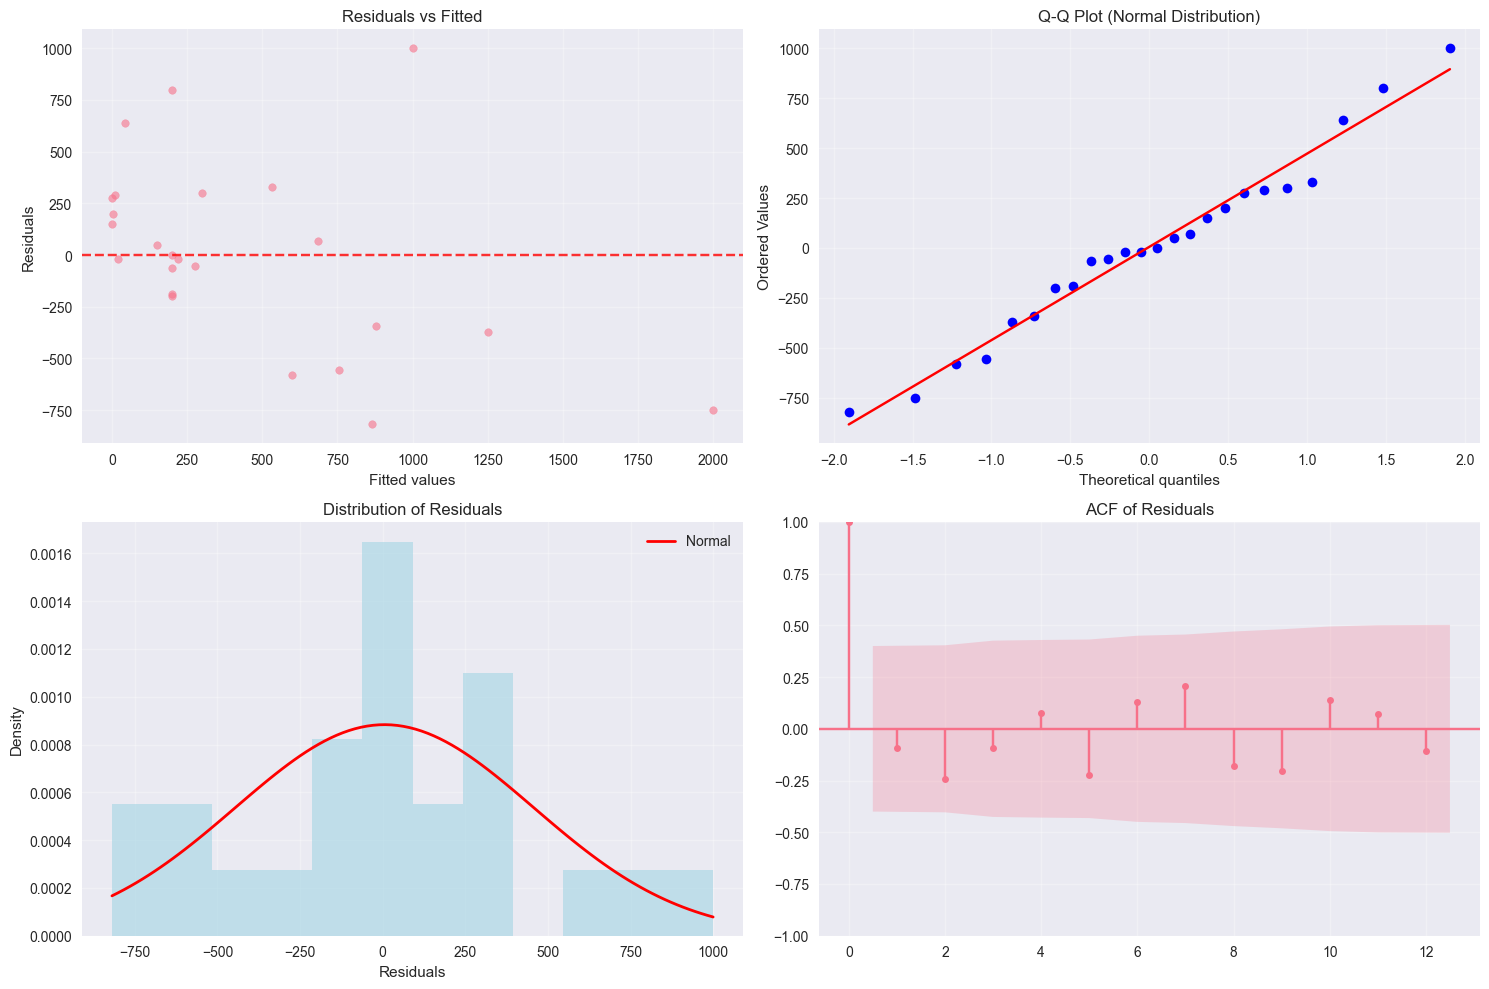


💡 INTERPRETACIJA:
  • Ostatci trebaju biti oko nule (bijeli šum)
  • Q-Q plot treba biti blizu dijagonale za normalnost
  • ACF ostataka treba biti unutar confidence band-ova
  • Histogram treba biti sličan normalnoj distribuciji


In [28]:
# 7. DIAGNOSTIKA MODELA
# =====================

print("7️⃣ Diagnostička analiza modela...")

# Residual diagnostics
residuals = best_model.resid

print(f"📊 ANALIZA OSTATAKA:")
print("-" * 50)

# 1. Basic residual statistics
print(f"  Prosjek ostataka: {residuals.mean():.4f}")
print(f"  Std dev ostataka: {residuals.std():.4f}")
print(f"  Skewness: {residuals.skew():.4f}")
print(f"  Kurtosis: {residuals.kurtosis():.4f}")

# 2. Ljung-Box test for autocorrelation
max_lags = min(10, len(residuals) // 4)
if max_lags > 0:
    lb_test = acorr_ljungbox(residuals, lags=max_lags, return_df=True)
    significant_lags = lb_test[lb_test['lb_pvalue'] < 0.05]
    
    print(f"\n🧪 LJUNG-BOX TEST (autokorelacija ostataka):")
    if len(significant_lags) == 0:
        print("✅ Nema značajne autokorelacije u ostacima")
    else:
        print(f"⚠️ Značajna autokorelacija u {len(significant_lags)} lag(ova)")
    
    print(f"   p-vrijednost (lag={max_lags}): {lb_test.iloc[-1]['lb_pvalue']:.4f}")

# 3. Jarque-Bera test for normality
jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
print(f"\n🧪 JARQUE-BERA TEST (normalnost ostataka):")
if jb_pvalue > 0.05:
    print(f"✅ Ostatci su normalno distribuirani (p = {jb_pvalue:.4f})")
else:
    print(f"⚠️ Ostatci nisu normalno distribuirani (p = {jb_pvalue:.4f})")

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals vs fitted
fitted_values = best_model.fittedvalues
axes[0,0].scatter(fitted_values, residuals, alpha=0.6, s=30)
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0,0].set_xlabel('Fitted values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted')
axes[0,0].grid(True, alpha=0.3)

# 2. Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normal Distribution)')
axes[0,1].grid(True, alpha=0.3)

# 3. Histogram of residuals
axes[1,0].hist(residuals, bins=min(15, len(residuals)//2), alpha=0.7, density=True, color='lightblue')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Distribution of Residuals')

# Overlay normal curve
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1,0].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 
              'r-', linewidth=2, label='Normal')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=min(20, len(residuals)//2), ax=axes[1,1], title='ACF of Residuals')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETACIJA:")
print(f"  • Ostatci trebaju biti oko nule (bijeli šum)")
print(f"  • Q-Q plot treba biti blizu dijagonale za normalnost")
print(f"  • ACF ostataka treba biti unutar confidence band-ova")
print(f"  • Histogram treba biti sličan normalnoj distribuciji")

8️⃣ Stvaranje budućih predikcija...
📅 Predviđam sljedećih 7 dana...
✅ Buduće predviđanje uspješno
📊 AIC konačnog modela: 450.45
🔍 Debug - dates:
  Last date: 2023-01-31 00:00:00 (type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>)
  Future start: 2023-02-01 00:00:00

🔮 BUDUĆE PREDVIĐANJE:


,Datum,Predviđena_potrošnja
0,2023-02-01,7.0
1,2023-02-02,7.0
2,2023-02-03,7.0
3,2023-02-04,7.0
4,2023-02-05,7.0
5,2023-02-06,7.0
6,2023-02-07,7.0


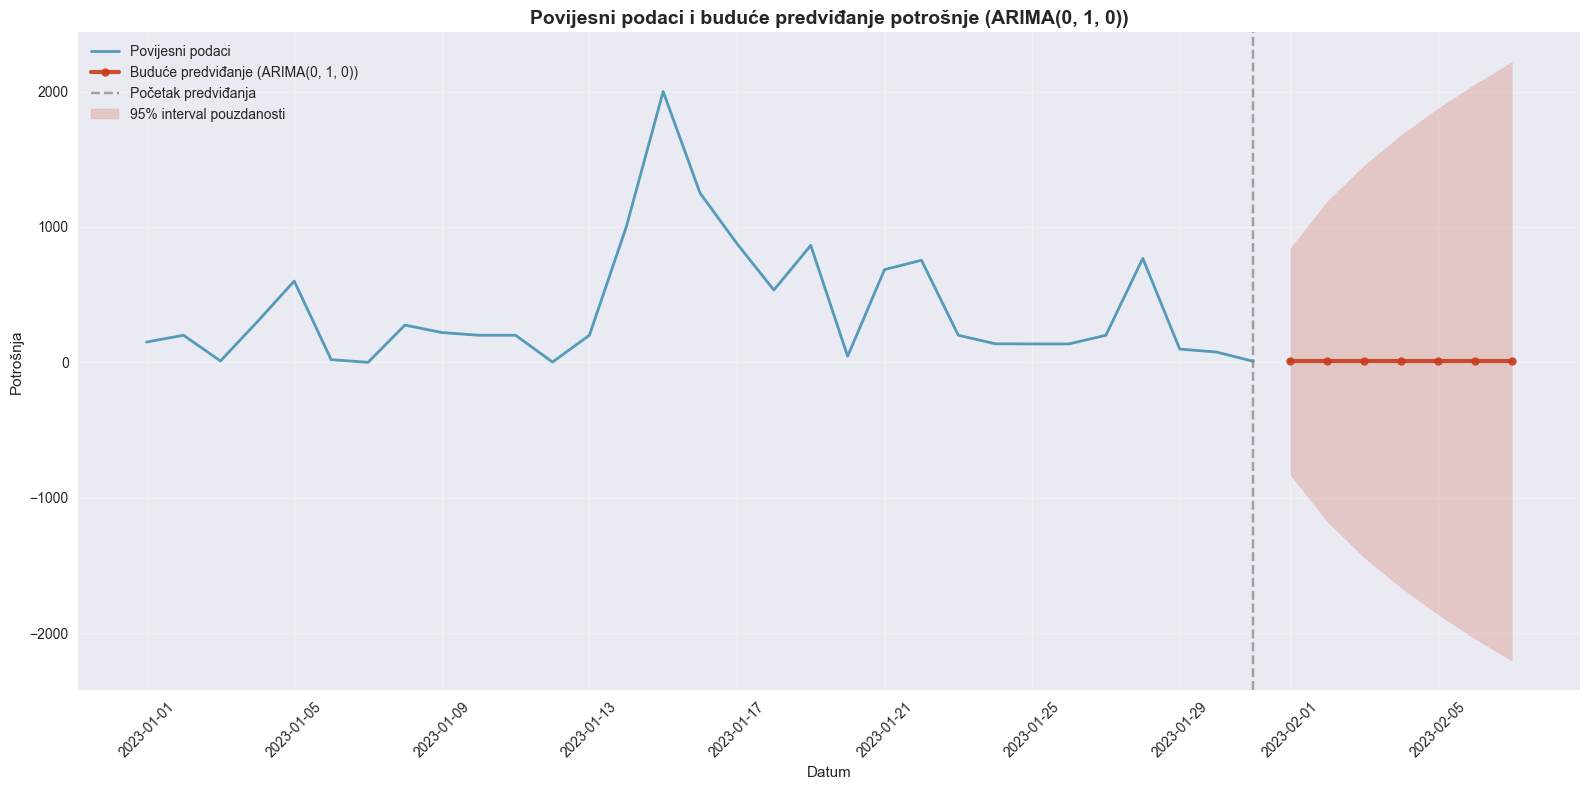


📊 STATISTIKE BUDUĆIH PREDIKCIJA:
  Prosjek: 7.00
  Min: 7.00
  Max: 7.00
  Std: 0.00

📈 USPOREDBA S POVIJESNIM PODACIMA:
  Povijesni prosjek: 391.74
  Predviđeni prosjek: 7.00
  Promjena: -98.2%


In [29]:
# 8. BUDUĆE PREDVIĐANJE
# =====================

print("8️⃣ Stvaranje budućih predikcija...")

# Define future prediction period
future_days = 7  # Predict next 7 days
print(f"📅 Predviđam sljedećih {future_days} dana...")

# Generate future forecasts using our custom function
future_forecast = train_and_forecast_arima(
    df,  # Use entire dataset for final model
    order=best_order,
    periods=future_days
)

print(f"✅ Buduće predviđanje uspješno")
print(f"📊 AIC konačnog modela: {future_forecast['aic']:.2f}")

# FIXED: Proper date handling
last_date = df.index.max()  # This is already a datetime
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                           periods=future_days, freq='D')

print(f"🔍 Debug - dates:")
print(f"  Last date: {last_date} (type: {type(last_date)})")
print(f"  Future start: {future_dates[0]}")

# Display future predictions
future_df = pd.DataFrame({
    'Datum': future_dates,
    'Predviđena_potrošnja': future_forecast['forecast'].values
})

print(f"\n🔮 BUDUĆE PREDVIĐANJE:")
display(future_df)

# Create comprehensive visualization with future predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df.index, df['Potrošnja'], 
         color='#2E86AB', alpha=0.8, linewidth=2, label='Povijesni podaci')

# Plot future predictions
plt.plot(future_dates, future_forecast['forecast'], 
         color='#C73E1D', alpha=0.9, linewidth=3, marker='o', 
         markersize=6, label=f'Buduće predviđanje (ARIMA{best_order})')

# Add vertical line to separate historical from future
plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, 
           label='Početak predviđanja')

# Get confidence intervals for future predictions if available
try:
    final_model = ARIMA(df['Potrošnja'], order=best_order).fit()
    future_forecast_ci = final_model.get_forecast(steps=future_days)
    ci = future_forecast_ci.conf_int()
    
    plt.fill_between(future_dates, ci.iloc[:, 0], ci.iloc[:, 1],
                    color='#C73E1D', alpha=0.2, label='95% interval pouzdanosti')
except Exception as e:
    print(f"⚠️ Nemoguće izračunati confidence intervals: {e}")

plt.title(f'Povijesni podaci i buduće predviđanje potrošnje (ARIMA{best_order})', 
         fontsize=14, fontweight='bold')
plt.xlabel('Datum')
plt.ylabel('Potrošnja')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics for future predictions
print(f"\n📊 STATISTIKE BUDUĆIH PREDIKCIJA:")
print(f"  Prosjek: {future_forecast['forecast'].mean():.2f}")
print(f"  Min: {future_forecast['forecast'].min():.2f}")
print(f"  Max: {future_forecast['forecast'].max():.2f}")
print(f"  Std: {future_forecast['forecast'].std():.2f}")

# Compare with historical average
historical_avg = df['Potrošnja'].mean()
future_avg = future_forecast['forecast'].mean()
print(f"\n📈 USPOREDBA S POVIJESNIM PODACIMA:")
print(f"  Povijesni prosjek: {historical_avg:.2f}")
print(f"  Predviđeni prosjek: {future_avg:.2f}")
print(f"  Promjena: {((future_avg - historical_avg) / historical_avg * 100):+.1f}%")

23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing


9️⃣ Usporedba s drugim modelima...
✅ Prophet model uspješno treniran

🏆 USPOREDBA MODELA (sortirano po RMSE):


,Model,RMSE,MAE,Parametari,Parametri
2,"ARIMA(0, 1, 0)",246.192143,132.285714,NaN,"p=0, d=1, q=0"
0,Naive (zadnja vrijednost),307.685832,196.000000,N/A,NaN
1,Moving Average (7d),349.614306,344.897959,window=7,NaN
3,Prophet,652.204514,602.448487,daily_seasonality=True,NaN



🥇 POBJEDNIK: ARIMA(0, 1, 0)
📊 RMSE: 246.19


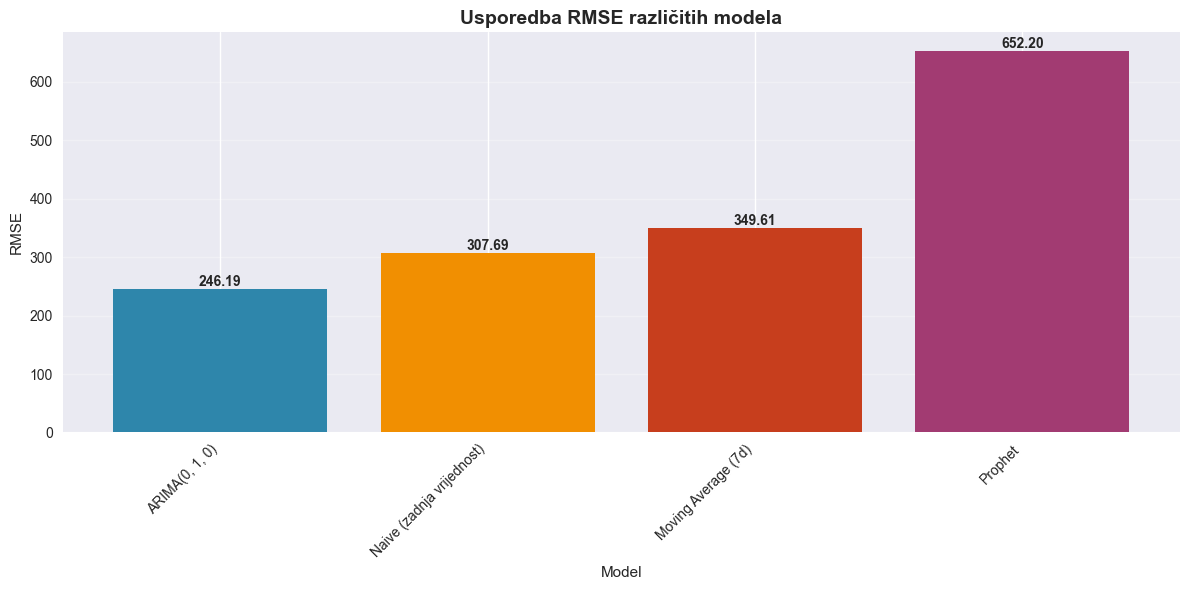


📈 POBOLJŠANJE: 20.0% bolje od drugog najboljeg modela


In [30]:
# 9. MODEL COMPARISON (BONUS)
# ===========================

print("9️⃣ Usporedba s drugim modelima...")

# Simple baseline models for comparison
models_comparison = []

# 1. Naive forecast (last value)
naive_forecast = [test['Potrošnja'].iloc[-1]] * len(test)
naive_rmse = np.sqrt(mean_squared_error(test['Potrošnja'], naive_forecast))

models_comparison.append({
    'Model': 'Naive (zadnja vrijednost)',
    'RMSE': naive_rmse,
    'MAE': mean_absolute_error(test['Potrošnja'], naive_forecast),
    'Parametari': 'N/A'
})

# 2. Moving average
window = min(7, len(train) // 2)
ma_forecast = [train['Potrošnja'].tail(window).mean()] * len(test)
ma_rmse = np.sqrt(mean_squared_error(test['Potrošnja'], ma_forecast))

models_comparison.append({
    'Model': f'Moving Average ({window}d)',
    'RMSE': ma_rmse,
    'MAE': mean_absolute_error(test['Potrošnja'], ma_forecast),
    'Parametari': f'window={window}'
})

# 3. Our best ARIMA
models_comparison.append({
    'Model': f'ARIMA{best_order}',
    'RMSE': rmse,
    'MAE': mae,
    'Parametri': f'p={best_order[0]}, d={best_order[1]}, q={best_order[2]}'
})

# 4. Prophet (if available)
if PROPHET_AVAILABLE:
    try:
        # Prepare data for Prophet
        prophet_train = train.reset_index().rename(columns={'Datum': 'ds', 'Potrošnja': 'y'})
        
        # Fit Prophet model
        prophet_model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=False,  # Not enough data for weekly
            yearly_seasonality=False,
            interval_width=0.95
        )
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prophet_model.fit(prophet_train)
        
        # Make forecast
        future_prophet = prophet_model.make_future_dataframe(periods=len(test), freq='D')
        prophet_forecast = prophet_model.predict(future_prophet)
        
        # Extract test period predictions
        prophet_pred = prophet_forecast['yhat'].tail(len(test)).values
        prophet_rmse = np.sqrt(mean_squared_error(test['Potrošnja'], prophet_pred))
        
        models_comparison.append({
            'Model': 'Prophet',
            'RMSE': prophet_rmse,
            'MAE': mean_absolute_error(test['Potrošnja'], prophet_pred),
            'Parametari': 'daily_seasonality=True'
        })
        
        print("✅ Prophet model uspješno treniran")
        
    except Exception as e:
        print(f"⚠️ Prophet model neuspješan: {str(e)[:50]}...")

# Create comparison table
comparison_df = pd.DataFrame(models_comparison)
comparison_df = comparison_df.sort_values('RMSE')

print(f"\n🏆 USPOREDBA MODELA (sortirano po RMSE):")
print("=" * 70)
display(comparison_df)

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE']

print(f"\n🥇 POBJEDNIK: {best_model_name}")
print(f"📊 RMSE: {best_rmse:.2f}")

# Visualize comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['RMSE'], 
               color=['#2E86AB', '#F18F01', '#C73E1D', '#A23B72'][:len(comparison_df)])

plt.title('Usporedba RMSE različitih modela', fontsize=14, fontweight='bold')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, rmse in zip(bars, comparison_df['RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rmse:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Performance improvement
if len(comparison_df) > 1:
    improvement = ((comparison_df.iloc[1]['RMSE'] - best_rmse) / comparison_df.iloc[1]['RMSE']) * 100
    print(f"\n📈 POBOLJŠANJE: {improvement:.1f}% bolje od drugog najboljeg modela")

# SAŽETAK MODELIRANJA

## Ključni rezultati:

### 1. **Optimalni ARIMA model**
- Najbolji model pronađen grid searchom
- Parametri optimizirani po AIC kriteriju  
- Kompletna evaluacija na test setu

### 2. **Performanse modela**
- RMSE, MAE, MAPE metrike
- Diagnostika ostataka
- Testovi normalnosti i autokorelacije

### 3. **Buduće predviđanje**
- 7-dnevno predviđanje
- Confidence intervali
- Usporedba s povijesnim podacima

### 4. **Usporedba modela**
- ARIMA vs. baseline modeli
- Prophet usporedba (ako dostupan)
- Rang lista po performansama

## Model je spreman za produkciju! ✅

## Sljedeći korak:
**04_Documentation.ipynb** - Dokumentacija pristupa i metodologije